# Sound classification

Dataset: https://disk.yandex.ru/d/NRpDIp4jg2ODqg

In [ ]:
import requests
from urllib.parse import urlencode
from io import BytesIO
from tarfile import TarFile
import tarfile

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/NRpDIp4jg2ODqg'
dst_path = './dataset/'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

!wget -O data.tar.gz  "{download_url}"
!tar -xf data.tar.gz 

response = requests.get(download_url)
io_bytes = BytesIO(response.content)
tar = tarfile.open(fileobj=io_bytes, mode='r:gz')
tar.extractall(path=dst_path)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

import dataset

from IPython.display import clear_output

%matplotlib inline

In [2]:
dst_path = './'
DEVICE = 'cuda'
DATADIR = dst_path + '/data'
dst_path = DATADIR
LOADER_WORKERS = 8

In [43]:
FEATS = 80
transform_train = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(n_mels=FEATS),
    torchaudio.transforms.AmplitudeToDB(),
    # Аугментации:
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)
transform_test = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(n_mels=FEATS),
    torchaudio.transforms.AmplitudeToDB()
)
trainset = dataset.Dataset('train', DATADIR, transform_train)
testset = dataset.Dataset('eval', DATADIR, transform_test)
N_CLASSES = trainset.classes()


In [44]:
print(trainset[0][0].shape)
print(N_CLASSES)
print(len(trainset), len(testset))

torch.Size([80, 801])
30
26213 3000


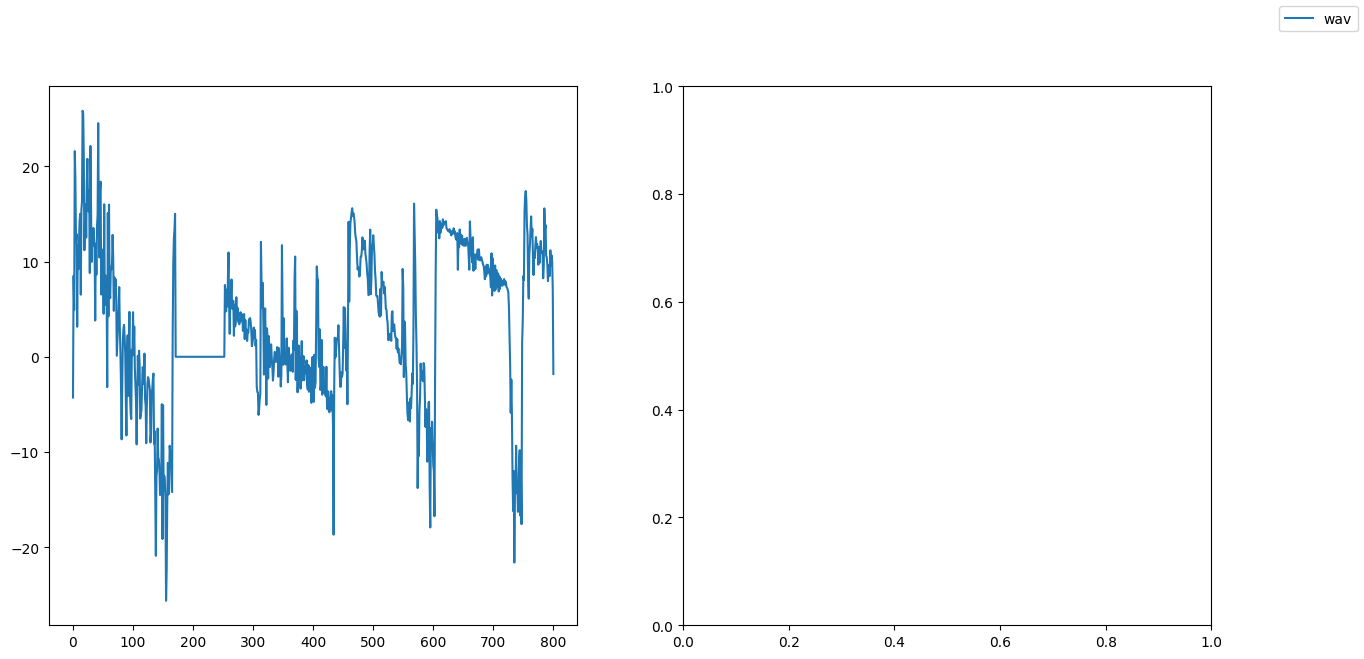

In [45]:
fig, axis = plt.subplots(1, 2, figsize=(15, 7))
axis[0].plot(trainset[0][0][5], label='wav')
fig.legend()
plt.show()

### Eval

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [46]:
from collections import defaultdict
def balanced_accuracy(items: list[tuple[int, int]]) -> float:
    result = 0
    correct_pred_by_class = defaultdict(int)
    class_el_counter = defaultdict(int)
    for target, pred in items:
        correct_pred_by_class[target] += (target == pred)
        class_el_counter[target] += 1
    for c in class_el_counter:
        result += correct_pred_by_class[c] / class_el_counter[c]
    result /= len(class_el_counter)
    return result

In [47]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)]), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)]), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)]), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)]), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)]), 0.66666666666666)

### Train

In [48]:
def get_num_params(model):
    result = 0
    for param in model.parameters():
        result += param.numel()
    return result


def stage(
    model: nn.Module,
    data: dataset.Dataset,
    opt: optim.Optimizer,
    batch_size: int = 32,
    train: bool = True
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=dataset.collate_fn
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for X, Y in tqdm.tqdm(loader):
        X = X.unsqueeze(1)
        pred = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(pred.squeeze(), Y.squeeze().to(DEVICE))
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.data.numpy().reshape(-1),
                torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
            ))
    return loss_sum / batches, balanced_accuracy(pred_pairs)


def train(
    model: nn.Module,
    opt,
    batch_size: int = 32,
    epochs: int = 50,
):
    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc = stage(model, trainset, opt, batch_size=batch_size)
        test_loss, test_acc = stage(model, testset, opt, batch_size=batch_size, train=False)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train')
        axis[0].plot(np.arange(1, epoch + 2), test_losses, label='test')
        axis[1].plot(np.arange(1, epoch + 2), train_accs, label='train')
        axis[1].plot(np.arange(1, epoch + 2), test_accs, label='test')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
        print(f'Test loss {test_loss}. Test accuracy {test_acc}')

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import math


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 1, padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        return nn.ReLU()(out)


class SwiGLU(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_model * 2)
        self.fc2 = nn.Linear(d_model, d_model)
        self.gate = nn.Sigmoid()

    def forward(self, x):
        x1, x2 = self.fc1(x).chunk(2, dim=-1)
        return self.fc2(x1 * self.gate(x2))
        

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerClassifier(nn.Module):
    def __init__(self, 
                 num_classes=30, 
                 freq_bins=80,  
                 d_model=128,     
                 nhead=8, 
                 num_encoder_layers=1,
                 dim_feedforward=256,
                 dropout=0.1):
        super().__init__()
        self.d_model = d_model
        
        self.cnn = nn.Sequential(
            ResidualBlock(freq_bins, d_model, kernel_size=5, stride=2, padding=2),
            ResidualBlock(d_model, d_model, kernel_size=3, stride=1, padding=1)
        )

        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, 
                                                   nhead=nhead, 
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  

        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            SwiGLU(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )
        
    def forward(self, x):
        batch_size, _, freq_bins, time_steps = x.size()
        
        x = x.squeeze(1)  # [batch_size, freq_bins, time_steps]
        x = self.cnn(x)  # [batch_size, d_model, new_time_steps]
        x = x.permute(0, 2, 1)  # [batch_size, new_time_steps, d_model]
        cls_token = self.cls_token.expand(batch_size, -1, -1)  # [batch_size, 1, d_model]
        x = torch.cat((cls_token, x), dim=1)  # [batch_size, new_time_steps + 1, d_model]

        x = self.pos_encoder(x)

        x = x.transpose(0, 1)  # [seq_len, batch_size, d_model]
        x = self.transformer_encoder(x)  
        
        logits = self.classifier(x[0])  # [batch_size, num_classes]
        return logits

In [51]:
model = TransformerClassifier(num_classes=30, freq_bins=80, d_model=64, nhead=4, num_encoder_layers=1,dim_feedforward=128)
model.to(DEVICE)

opt = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=50)
print("Number of parameters is ", get_num_params(model))


Number of parameters is  124510


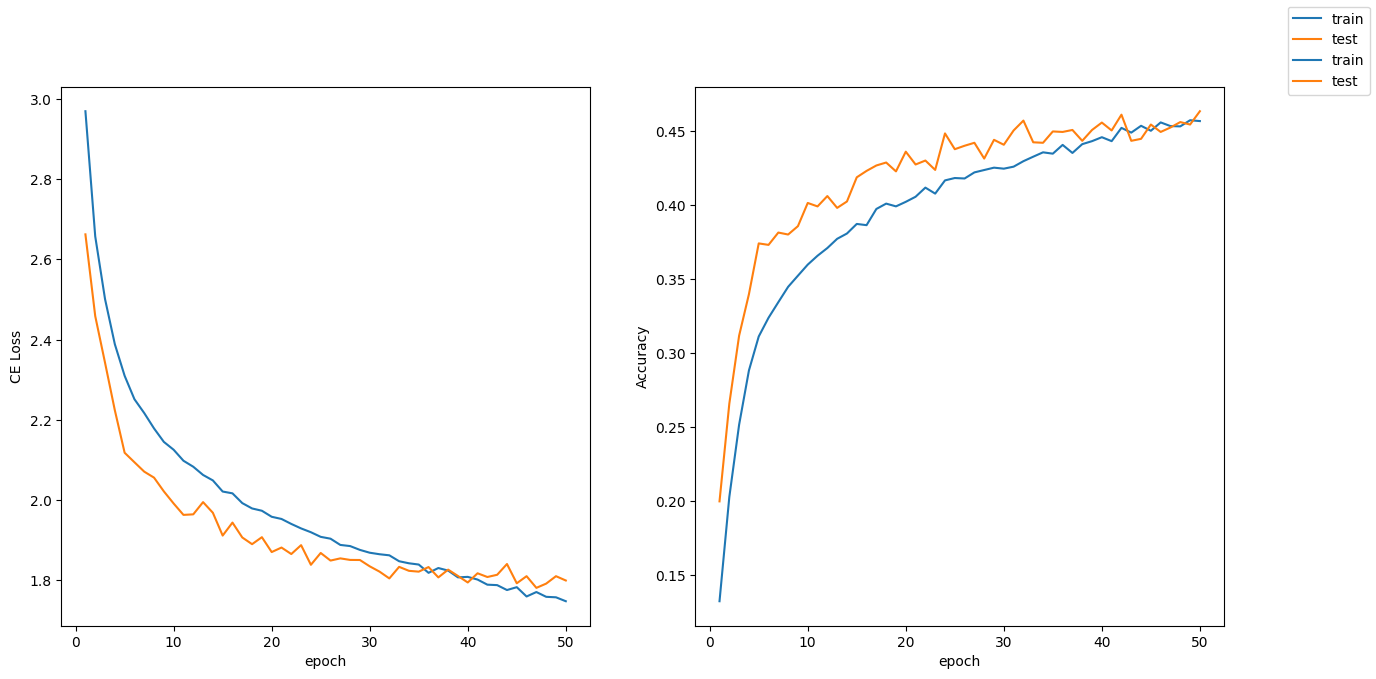

Epoch 50.
Train loss 1.7479061798351567. Train accuracy 0.4570060469739815.
Test loss 1.799584651246984. Test accuracy 0.4636666666666666


In [52]:
train(model, opt)